<font size="4">In this demonstration, we will do image classification using what was covered so far in the courses.</font>

<font size="4">We will use a simple Logistic Regression model to determine whether a given document image is an invoice or not.</font>

# **Libraries**

In [1]:
from collections import defaultdict
import os
from pathlib import Path
import random
from typing import Dict, List

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, 
    precision_recall_curve, PrecisionRecallDisplay
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm 

In [2]:
plt.rc("font", size=20) #controls default text size
plt.rc("axes", titlesize=20) #fontsize of the title
plt.rc("axes", labelsize=20) #fontsize of the x and y labels
plt.rc("xtick", labelsize=20) #fontsize of the x tick labels
plt.rc("ytick", labelsize=20) #fontsize of the y tick labels
plt.rc("legend", fontsize=20) #fontsize of the legend

# **Constants**

In [3]:
data_dir = Path("docs-sm")

In [4]:
image_size = 128
test_size = 0.2
random_seed = 16

In [5]:
random.seed(random_seed)
np.random.seed(random_seed)

# **Data**

<font size="4">For this demonstration we will only use part of the data.</font>

<font size="4">We will randomly select 50 samples from the **invoice** category and 10 samples from each other category (150)</font>

In [6]:
categories = ["invoice", "not_invoice"]

In [7]:
image_paths = dict(invoice=[], not_invoice=[])
for category_path in tqdm(list(data_dir.glob("*"))):
    category_name = category_path.name
    if category_name == "invoice":
        image_paths[categories[0]] = random.sample(list(category_path.glob("*")), 50)
    else:
        image_paths[categories[1]].extend(random.sample(list(category_path.glob("*")), 10))

  0%|          | 0/16 [00:00<?, ?it/s]

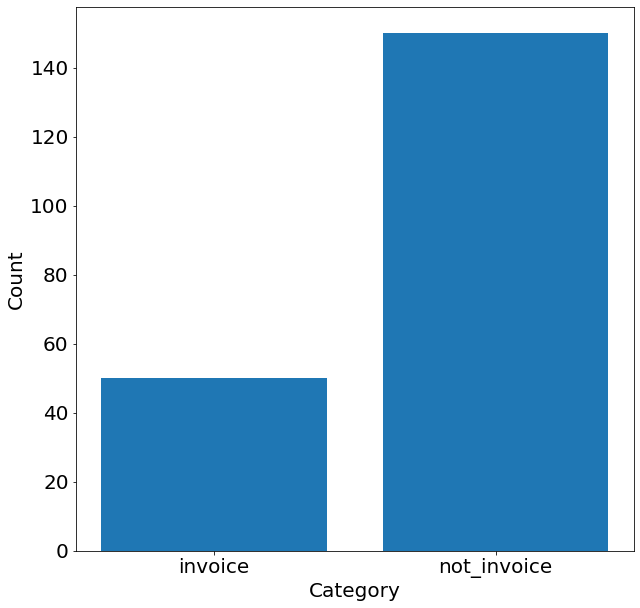

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(categories, [len(image_paths[category]) for category in categories])
ax.set_xlabel("Category")
ax.set_ylabel("Count")
plt.show()

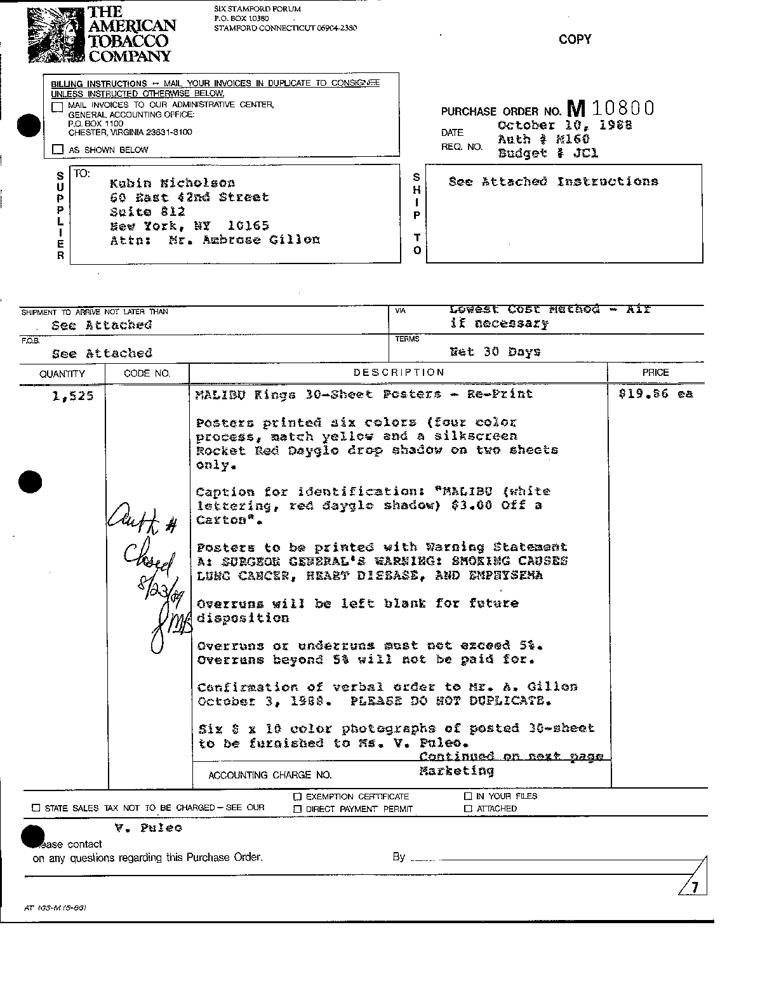

In [9]:
Image.open(random.choice([x for y in image_paths.values() for x in y]))

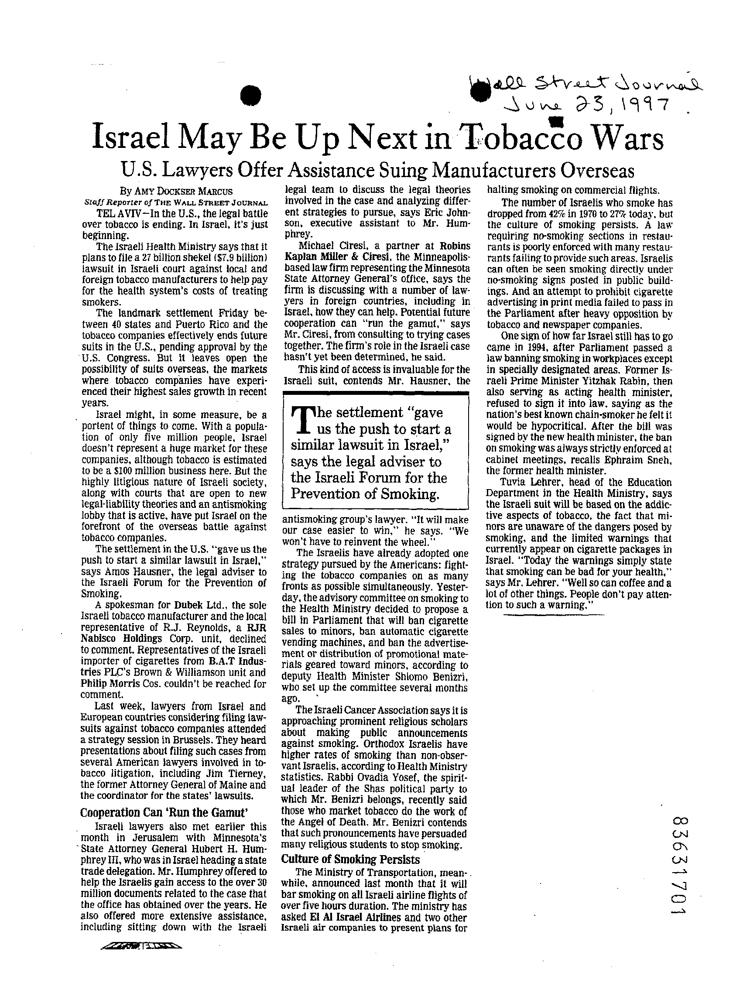

In [10]:
Image.open(random.choice([x for y in image_paths.values() for x in y]))

# **Data Preparation**

<font size="4">Before using the images we have to first normalize them and shrink them to the same size</font>

<font size="4">For that we will use </font>[<font size="4">OpenCV</font>](https://opencv.org/) <font size="4">(Open Source Computer Vision Library), an open source computer vision and machine learning software library. It was built to provide a common infrastructure for computer vision applications and to accelerate the use of machine perception in commercial products. </font>

In [11]:
def prepare_images(image_paths: Dict[str, List[Path]]) -> Dict[str, List[np.ndarray]]:
    image_data = dict()
    for category, image_path_list in tqdm(image_paths.items()):
        image_array_list = []
        for image_path in image_path_list:
            image = cv2.imread(os.fspath(image_path), cv2.IMREAD_GRAYSCALE)
            image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            image = cv2.resize(image, (image_size, image_size)).flatten()
            image_array = np.asarray(image)
            image_array_list.append(image_array)
        image_data[category] = image_array_list
    return image_data

In [12]:
image_data = prepare_images(image_paths)

  0%|          | 0/2 [00:00<?, ?it/s]

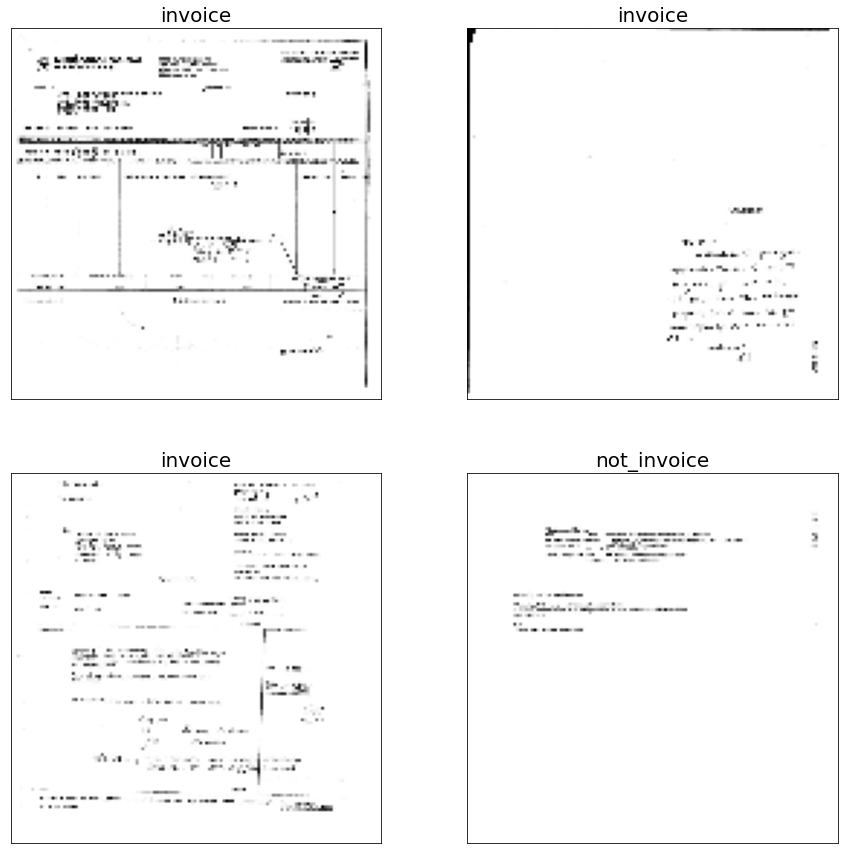

In [13]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

category = random.choice(list(image_data.keys()))
ax1.imshow(random.choice(image_data[category]).reshape(image_size, image_size), cmap="gray");
ax1.set_title(category)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

category = random.choice(list(image_data.keys()))
ax2.imshow(random.choice(image_data[category]).reshape(image_size, image_size), cmap="gray");
ax2.set_title(category)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

category = random.choice(list(image_data.keys()))
ax3.imshow(random.choice(image_data[category]).reshape(image_size, image_size), cmap="gray");
ax3.set_title(category)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

category = random.choice(list(image_data.keys()))
ax4.imshow(random.choice(image_data[category]).reshape(image_size, image_size), cmap="gray");
ax4.set_title(category)
ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

plt.show()

<font size="4">As we can see, not much information remains after shrinking and removing the color information from the images.</font>

<font size="4">**Question:** Is it still possible to distinguish between the two kinds of document images? Would a trained model be able to do it?</font>

# **Train-Test Split**

<font size="4">Now that we have finished with data preparation we can split the dataset and proceed with pre-processing and then training</font>

### Tasks:
* Compile the feature dataset (X) using the prepared images. You might find the numpy "vstack" method useful.
* Compile the labels (y)
* Split the data to training and test sets

In [42]:
X = np.vstack(image_data[categories[0]] + image_data[categories[1]])
y = np.array([1] * len(image_data[categories[0]]) + [0] * len(image_data[categories[1]]))

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify = y, random_state=random_seed)

# **Pre-Processing**

<font size="4">We standardize the data in order to guarantee the conversion of the algorithm used to train the Logistic Regression model.

### Task
* Standarize the data</font>

In [45]:
scaler = StandardScaler()

In [46]:
scaler.fit(X_train)

StandardScaler()

In [47]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# **Training**

### Task
* Train a logistic regression model
* Output the Accuracy score on the training data
* Output the Precision, Recall and F1 Score.
* Display the confusion matrix
* Plot the roc-auc curve
* Plot the precision-recall curve

In [48]:
model = LogisticRegression(max_iter=300, random_state=random_seed)

In [49]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=300, random_state=16)

## Reminder

* <font size="4">$Precision = \frac{True\_Positives}{True\_Positives + False\_Positives}$</font>

<font size="4">Precision attempts to answer the following question: What proportion of positive identifications was actually correct?</font>



* <font size="4">$Recall =\frac{True\_Positives}{True\_Positives + False\_Negatives}$</font>

<font size="4">Recall attempts to answer the following question: What proportion of actual positives was identified correctly?</font>



* <font size="4">$F1-Score = \frac{2 * Precision * Recall}{Precision + Recall}$</font>

In [50]:
y_train_pred = model.predict(X_train)

In [51]:
print(f"Accuracy on the training set: {accuracy_score(y_train, y_train_pred)*100}%")

Accuracy on the training set: 100.0%


In [52]:
print(classification_report(y_train, y_train_pred, labels=[1, 0], target_names=categories))

              precision    recall  f1-score   support

     invoice       1.00      1.00      1.00        40
 not_invoice       1.00      1.00      1.00       120

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



<font size="4">**Questions:**</font>

* <font size="4">Are the results good or bad?</font>
* <font size="4">How can we explain this outcome?</font>

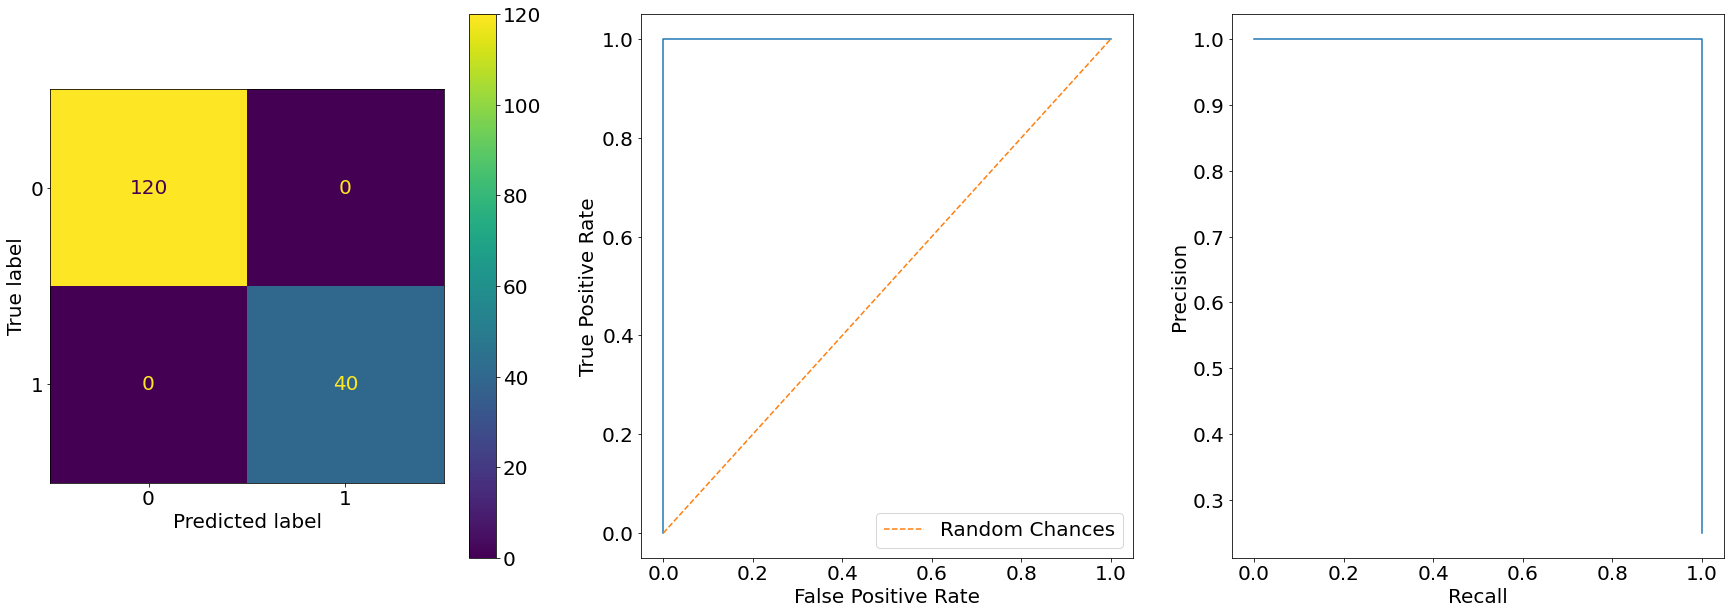

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
cm = confusion_matrix(y_train, y_train_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(ax=ax1)
y_train_score = model.decision_function(X_train)
fpr, tpr, _ = roc_curve(y_train, y_train_score, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(ax=ax2)
x = np.arange(0, 1.1, 0.1)
ax2.plot(x, x, "--", label="Random Chances")
ax2.legend(loc="lower right")
prec, recall, _ = precision_recall_curve(y_train, y_train_score, pos_label=model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
pr_display.plot(ax=ax3)
plt.show()

# **Evaluation**

<font size="4">We now evaluate the trained classifier on the test data.

### Task
Repeat the previous steps for the test data.</font>

In [54]:
y_pred = model.predict(X_test)

In [55]:
f"Accuracy on the test set: {accuracy_score(y_test, y_pred)*100}%"

'Accuracy on the test set: 70.0%'

In [56]:
print(classification_report(y_test, y_pred, labels=[1, 0], target_names=categories))

              precision    recall  f1-score   support

     invoice       0.25      0.10      0.14        10
 not_invoice       0.75      0.90      0.82        30

    accuracy                           0.70        40
   macro avg       0.50      0.50      0.48        40
weighted avg       0.62      0.70      0.65        40



<font size="4">**Questions:**</font>

* <font size="4">Are the results good or bad?</font>
* <font size="4">How can we explain this outcome?</font>
* <font size="4">How can we improve the results?</font>

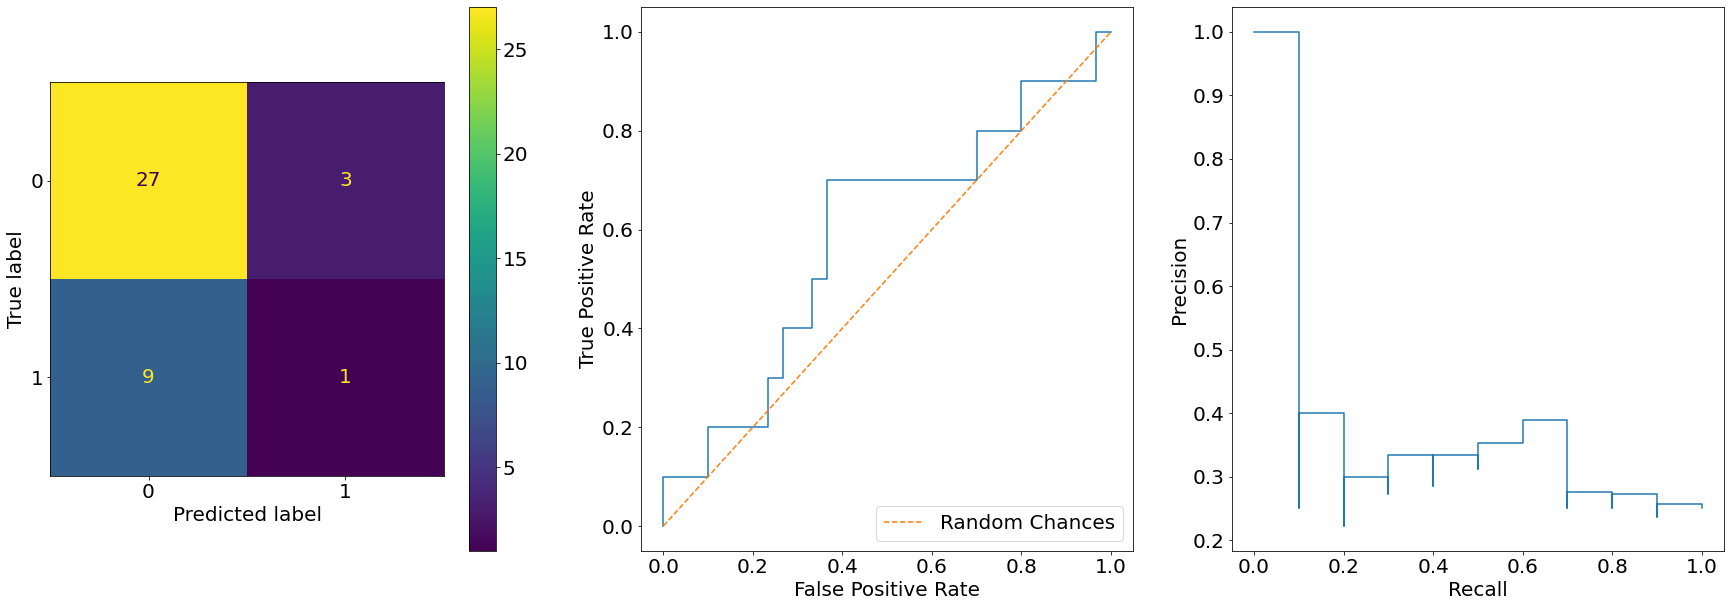

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
cm_display.plot(ax=ax1)
y_score = model.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot(ax=ax2)
x = np.arange(0, 1.1, 0.1)
ax2.plot(x, x, "--", label="Random Chances")
ax2.legend(loc="lower right")
prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
pr_display.plot(ax=ax3)
plt.show()

# **Advanced:** Fixing The Issues

***Task***
Can you suggest improvements to the previous system?

<font size="4">There are different approaches we can take to fix the issues with our data:</font>

* <font size="4">Collect more data</font>
* <font size="4">Select a different metric (Accuracy Paradox)</font>
* <font size="4">Take imbalance into account when doing a Train-Test Split(Stratified Splitting)</font>
* <font size="4">Oversample the minority class and/or Undersample the majority class</font>
* <font size="4">Generate synthetic data for the minority class</font>

## **Collect more data**
### Task
* Use balanced a balanced dataset and repeat the training and evualuation steps to compare
with the previous model

In [29]:
n_invoice_samples = 150
n_samples_other_category = 10

In [30]:
image_paths = dict(invoice=[], not_invoice=[])
for category_path in tqdm(list(data_dir.glob("*"))):
    category_name = category_path.name
    if category_name == "invoice":
        image_paths[categories[0]] = random.sample(list(category_path.glob("*")), n_invoice_samples)
    else:
        image_paths[categories[1]].extend(random.sample(list(category_path.glob("*")), n_samples_other_category))

image_data = prepare_images(image_paths)

X = np.vstack(image_data[categories[0]] + image_data[categories[1]])
y = np.array([1] * len(image_data[categories[0]]) + [0] * len(image_data[categories[1]]))
# We use stratification for the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

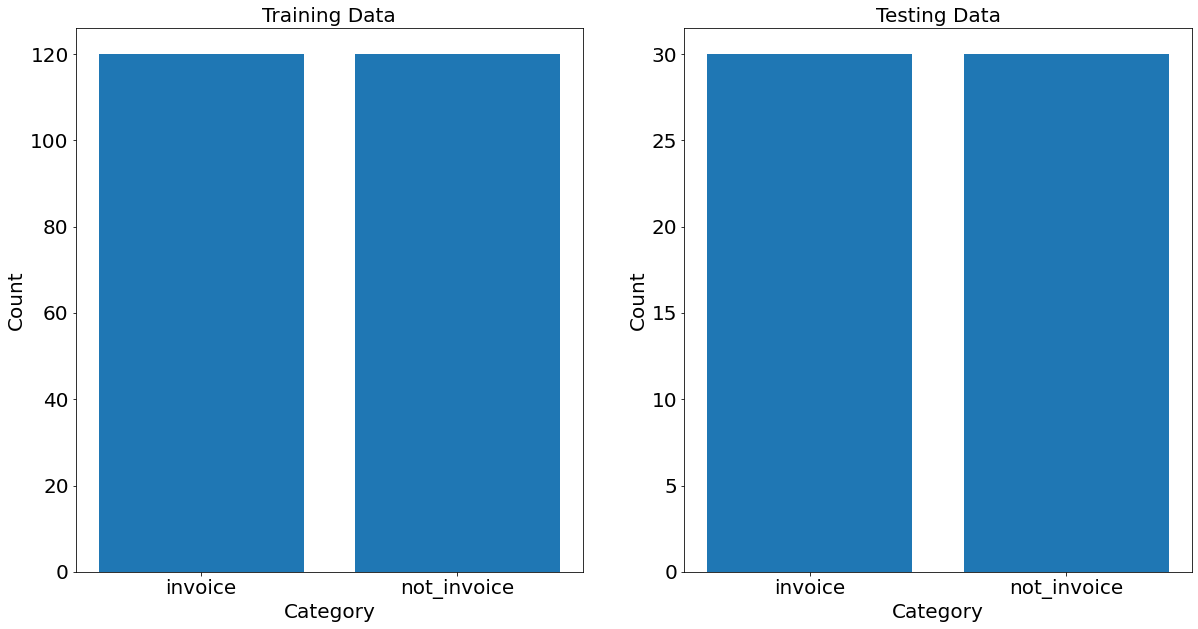

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.bar(categories, [np.sum(y_train == 1), np.sum(y_train == 0)])
ax1.set_xlabel("Category")
ax1.set_ylabel("Count")
ax1.set_title("Training Data")
ax2.bar(categories, [np.sum(y_test == 1), np.sum(y_test == 0)])
ax2.set_xlabel("Category")
ax2.set_ylabel("Count")
ax2.set_title("Testing Data")
plt.show()

In [32]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=300, random_state=random_seed))
])

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [33]:
print(classification_report(y_train, y_train_pred, labels=[1, 0], target_names=categories))

              precision    recall  f1-score   support

     invoice       1.00      1.00      1.00       120
 not_invoice       1.00      1.00      1.00       120

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [34]:
print(classification_report(y_test, y_pred, labels=[1, 0], target_names=categories))

              precision    recall  f1-score   support

     invoice       0.59      0.33      0.43        30
 not_invoice       0.53      0.77      0.63        30

    accuracy                           0.55        60
   macro avg       0.56      0.55      0.53        60
weighted avg       0.56      0.55      0.53        60



## **Oversample the minority class**
### Task
We are fortunate to have the possibility to balance the data, but that is not always the case 
in reality. In the following task, you will be balancing the dataset by oversampling the minority
class. You can look up the following import and how it might be helpful for you.
* Repeat the training and evaluation steps and compare the results

In [58]:
from imblearn.over_sampling import ADASYN

In [36]:
n_invoice_samples = 50
n_samples_other_category = 10

In [37]:
image_paths = dict(invoice=[], not_invoice=[])
for category_path in tqdm(list(data_dir.glob("*"))):
    category_name = category_path.name
    if category_name == "invoice":
        image_paths[categories[0]] = random.sample(list(category_path.glob("*")), n_invoice_samples)
    else:
        image_paths[categories[1]].extend(random.sample(list(category_path.glob("*")), n_samples_other_category))

image_data = prepare_images(image_paths)

X = np.vstack(image_data[categories[0]] + image_data[categories[1]])
y = np.array([1] * len(image_data[categories[0]]) + [0] * len(image_data[categories[1]]))
# We use stratification for the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=test_size, random_state=random_seed)
# We oversample the training data
oversampler = ADASYN(random_state=random_seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

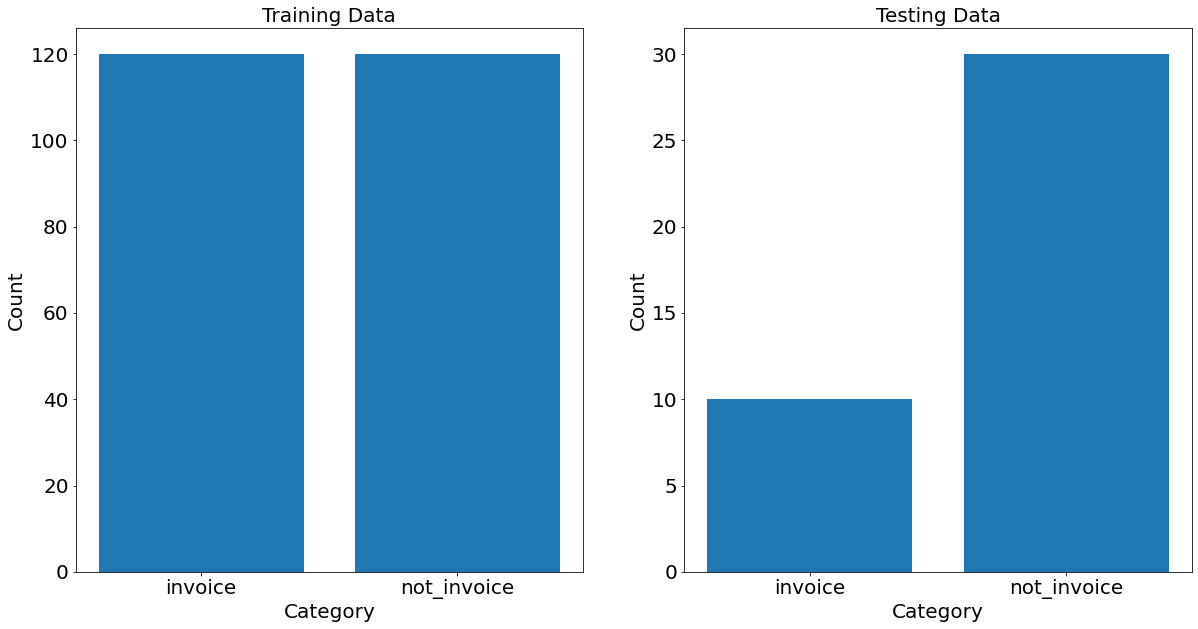

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.bar(categories, [np.sum(y_train == 1), np.sum(y_train == 0)])
ax1.set_xlabel("Category")
ax1.set_ylabel("Count")
ax1.set_title("Training Data")
ax2.bar(categories, [np.sum(y_test == 1), np.sum(y_test == 0)])
ax2.set_xlabel("Category")
ax2.set_ylabel("Count")
ax2.set_title("Testing Data")
plt.show()

In [39]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=300, random_state=random_seed))
])

model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

In [40]:
print(classification_report(y_train, y_train_pred, labels=[1, 0], target_names=categories))

              precision    recall  f1-score   support

     invoice       1.00      1.00      1.00       120
 not_invoice       1.00      1.00      1.00       120

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [41]:
print(classification_report(y_test, y_pred, labels=[1, 0], target_names=categories))

              precision    recall  f1-score   support

     invoice       0.33      0.10      0.15        10
 not_invoice       0.76      0.93      0.84        30

    accuracy                           0.73        40
   macro avg       0.55      0.52      0.49        40
weighted avg       0.65      0.72      0.67        40



# Useful Resources

* [<font size="4">Precision and Recall: A Tug of War</font>](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
* [<font size="4">The Accuracy Paradox</font>](https://en.wikipedia.org/wiki/Accuracy_paradox)
* [<font size="4">Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset
</font>](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
* [<font size="4">Imbalanced-learn</font>](https://imbalanced-learn.org/stable/)